<div align="center">
 <img src="http://www.di.uoa.gr/themes/corporate_lite/logo_en.png" title="Department of Informatics and Telecommunications - University of Athens" align="center" /> 
</div>

<br>

---

<div align="center"> 
  <font size="4"><b>Bachelor Thesis</b> </font>
</div>
<br>
<div align="center"> 
  <font size="5">
      <b>Entity Resolution in Dissimilarity Spaces  <br></b> 
    </font>
     <br>
     <font size="3">
        Results notebook     
    </font>
</div>

---

<div align="center"> 
    <font size="4">
         <b>Konstantinos Nikoletos, BS Student</b>
     </font>
</div>
<br>
<div align="center"> 
    <font size="4">
     <b> Dr. Alex Delis</b>,  Professor NKUA <br> 
     <b> Dr. Vassilis Verikios</b>, Professor Hellenic Open University
    </font>
</div>
<br>
<div align="center"> 
    <font size="2">Athens</font>
</div>
<div align="center"> 
    <font size="2">January 2021 - Ongoing</font>
</div>


---

# __Code injection__

## Import of libraries

In [1]:
import pandas as pd
import numpy as np
import collections
import editdistance
import string
import sklearn
import pandas_read_xml as pdx
import time
import warnings
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import math
import os
import scipy.special as special
import igraph
import networkx as nx
import itertools 
import sklearn

from tqdm.notebook import tqdm as tqdm
from scipy.spatial.distance import directed_hausdorff,hamming
from scipy.stats._stats import _kendall_dis
from scipy.stats import spearmanr,kendalltau,pearsonr,kruskal,mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity
from nltk.metrics.distance import jaro_similarity,jaro_winkler_similarity,jaccard_distance
from sklearn.metrics import jaccard_score,accuracy_score,auc,f1_score,recall_score,precision_score,classification_report
from scipy.sparse import csr_matrix
from scipy import sparse
from scipy import stats 
from scipy.spatial.distance import euclidean,hamming,jaccard
from matplotlib.patches import Rectangle
from sklearn.metrics import ndcg_score
from datetime import datetime
from sklearn.decomposition import PCA 
from numpy.linalg import svd

plt.style.use('seaborn-white') # plot style

Automated refresh on the notebook

In [2]:
%load_ext autoreload
%autoreload 2

## Main model dependency

In [3]:
from model import RankedWTAHash, customClassificationReport, report, set_params

## Utilities

In [33]:
from utils.classification import MMD2, myMMD2
from plot.heatmap import myHeatmap
from plot.confusion_matrix import create_ConfusionMatrix
from plot.dimension_reduction import SpaceVisualization2D, SpaceVisualization3D, SpaceVisualizationEmbeddings2D, SpaceVisualizationEmbeddings3D
from plot.heatmap import similarityProbsHeatMap, similarityProbsHeatMapWithClusters

### Dataset utils

In [5]:
from datasets.common.create_dataset import createDataset, createTrueLabels

### GridSearch function

In [6]:
from utils.grid_search import GridSearch

### Custom metrics

In [7]:
from utils.metrics import spearman_footrule_distance, kendall_top_k, rbo


# __Dataset injection__

## Load data from Drive in Colab

In [8]:
# # Opening data file
# import io
# from google.colab import drive

# drive.mount('/content/drive',force_remount=True)

# fpcora = r"/content/drive/My Drive/ERinDS/CORA.xml"
# fpcora_gold = r"/content/drive/My Drive/ERinDS/cora_gold.csv"

## Load data from disk for Jupyter

### JedAI Dirty datasets

#### CORA

In [9]:
CORA_groundTruth = os.path.abspath("../data/coraIdDuplicates.csv")
CORA = os.path.abspath("../data/coraProfiles.csv")
CORA_groundTruth = pd.read_csv(CORA_groundTruth,sep='|',header=None,names=['id1','id2'])
CORA_groundTruth=CORA_groundTruth.sort_values(by=['id1','id2'],ignore_index=True)
CORA = pd.read_csv(CORA,sep='|')
CORA

Entity Id            address  \
0             0  los alamitos, ca:   
1             1                NaN   
2             2                NaN   
3             3                NaN   
4             4                NaN   
...         ...                ...   
1290       1290                NaN   
1291       1291                NaN   
1292       1292                NaN   
1293       1293                NaN   
1294       1294                NaN   

                                                 author  \
0     p. auer, n. cesa-bianchi, y. freund, and r. e....   
1     a. blum, m. furst, m. j. kearns, and richard j...   
2     avrim blum, merrick furst, michael kearns, and...   
3     avrim blum, merrick furst, michael kearns, and...   
4              a. blum, m. furst, m. kearns, r. lipton.   
...                                                 ...   
1290               robert e. schapire and yoram singer.   
1291  schapire, r. e., freund, y., bartlett, p., & l...   
1292   robert e. schapire and yoram singer. boostexter:   
1293                   robert e. schapire yoram singer.   
1294                   robert e. schapire yoram singer.   

                              editor institution month  \
0                                NaN         NaN   NaN   
1                                NaN         NaN   NaN   
2                                NaN         NaN   NaN   
3     in douglas r. stinson, editor,         NaN   NaN   
4                                NaN         NaN   NaN   
...                              ...         ...   ...   
1290                             NaN         NaN   NaN   
1291                             NaN         NaN   NaN   
1292                             NaN         NaN   NaN   
1293                             NaN         NaN   NaN   
1294                             NaN         NaN   NaN   

                                            note              pages  \
0                                            NaN       pp. 322-331.   
1                                            NaN  pages 24.1-24.10,   
2                                            NaN  pages 24.1-24.10,   
3     lecture notes in computer science no. 773.     pages 278-291.   
4                                            NaN                NaN   
...                                          ...                ...   
1290                                         NaN                NaN   
1291           annals of statistics (to appear).                NaN   
1292                                         NaN                NaN   
1293               submitted for publication. 17                NaN   
1294                  submitted for publication.                NaN   

                         publisher  \
0     ieee computer society press,   
1                              NaN   
2                              NaN   
3                        springer,   
4                              NaN   
...                            ...   
1290                           NaN   
1291                           NaN   
1292                           NaN   
1293                           NaN   
1294                           NaN   

                                                  title  \
0     'gambling in a rigged casino: the adversarial ...   
1     cryptographic primitives based on hard learnin...   
2     cryptographic primitives based on hard learnin...   
3     cryptographic primitives based on hard learnin...   
4     cryptographic primitives based on hard learnin...   
...                                                 ...   
1290  improved boosting algorithms using confidence-...   
1291  boosting the margin: a new explanation for the...   
1292  a system for multiclass multi-label text categ...   
1293  improved boosting algorithms using confidence-...   
1294  improved boosting algorithms using confidence-...   

                                                  venue volume     year  \
0     in proc. 36th annual symposium on foundatio

In [10]:
CORA_groundTruth.head(10)

id1  id2
0    1    2
1    1    3
2    1    4
3    2    3
4    2    4
5    3    4
6    5    6
7    5    7
8    5    8
9    5    9

#### CENSUS

In [11]:
CENSUS_groundTruth = os.path.abspath("../data/censusIdDuplicates.csv")
CENSUS = os.path.abspath("../data/censusProfiles.csv")
CENSUS_groundTruth = pd.read_csv(CENSUS_groundTruth,sep='|',header=None,names=['id1','id2'])
CENSUS = pd.read_csv(CENSUS,sep='|')
# CENSUS

In [12]:
# CENSUS_groundTruth

#### CDDB

In [13]:
CDDB_groundTruth = os.path.abspath("../data/cddbIdDuplicates.csv")
CDDB = os.path.abspath("../data/cddbProfiles.csv")
CDDB_groundTruth = pd.read_csv(CDDB_groundTruth,sep='/00000',engine='python',header=None,names=['id1','id2'])
CDDB = pd.read_csv(CDDB,sep='/00000',engine='python')
# CDDB

In [14]:
# CDDB_groundTruth

#### DBLP - ACM

In [15]:
ACM = os.path.abspath("../data/ACM.csv")
DBLP = os.path.abspath("../data/DBLP2.csv")
ACM_DBLP_trueValues = os.path.abspath("../data/DBLP-ACM_perfectMapping.csv")
ACM = pd.read_csv(ACM)
DBLP = pd.read_csv(DBLP, encoding='latin-1')
ACM_DBLP_trueValues = pd.read_csv(ACM_DBLP_trueValues)

#### CORA - 1st edition

In [16]:
fpcora = os.path.abspath("../data/cora1stEdition/CORA.xml")
fpcora_gold = os.path.abspath("../data/cora1stEdition/cora_gold.csv")
CORA1 = pdx.read_xml(fpcora,['CORA', 'NEWREFERENCE'],root_is_rows=False)
CORA1['@id'] = pd.to_numeric(CORA1['@id']).subtract(1)
CORA1_groundTruth = pd.read_csv(fpcora_gold,sep=';')
CORA1_groundTruth['id1'] = pd.to_numeric(CORA1_groundTruth['id1']).subtract(1)
CORA1_groundTruth['id2'] = pd.to_numeric(CORA1_groundTruth['id2']).subtract(1)

# __CORA Evaluation__

### Shuffle data

In [17]:
CORA_shuffled = CORA.sample(frac=1).reset_index(drop=True)
# CORA_shuffled

In [18]:
fields = [
     'address',
     'author',
     'editor',
     'institution',
     'month',
     'note',
     'pages',
     'publisher',
     'title',
     'venue',
     'volume',
     'year',
     'Unnamed: 13'
]

# fields = [
#      'author',
#      'title',
# ]


# CORA
data, true_matrix = createDataset(CORA, CORA_groundTruth, fields, 'Entity Id')

# Toy CORA
# data, true_matrix = createDataset(CORA.head(15), CORA_groundTruth.head(50), fields, 'Entity Id')

# Old CORA
# data, true_matrix = createDataset(CORA1, CORA1_groundTruth, fields, '@id')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

__Clique construction for visualization purposes__

In [19]:
labels_groundTruth, numOfObjWithoutDups, groups = createTrueLabels(CORA['Entity Id'].tolist(),CORA_groundTruth)            
data_length = [ len(x) for x in data ]

### CORA inspection

In [20]:
specs = {
    'Objects without any duplicates' : numOfObjWithoutDups-len(groups), 
    'Objects with at least one duplicate' : sum([len(x) for x in groups]),
    'Total number of objects' : CORA.shape[0], 
    'Number of ER clusters' : len(groups),
    'Dataset size' : len(data), 
    'Average length' : np.mean(data_length), 
    'Min length' : min(data_length), 
    'Max length' : max(data_length), 
    'Median length' : np.median(data_length)
}
specsCoraDf = pd.DataFrame(list(specs.items()), columns=['Spec','#number'])
specsCoraDf[['#number']] = specsCoraDf[['#number']].astype(int)
specsCoraDf

Spec  #number
0       Objects without any duplicates       19
1  Objects with at least one duplicate     1276
2              Total number of objects     1295
3                Number of ER clusters       93
4                         Dataset size     1295
5                       Average length      164
6                           Min length       38
7                           Max length      366
8                        Median length      164

#### Dataset attributes

In [21]:
list(CORA.columns)

['Entity Id',
 'address',
 'author',
 'editor',
 'institution',
 'month',
 'note',
 'pages',
 'publisher',
 'title',
 'venue',
 'volume',
 'year',
 'Unnamed: 13']

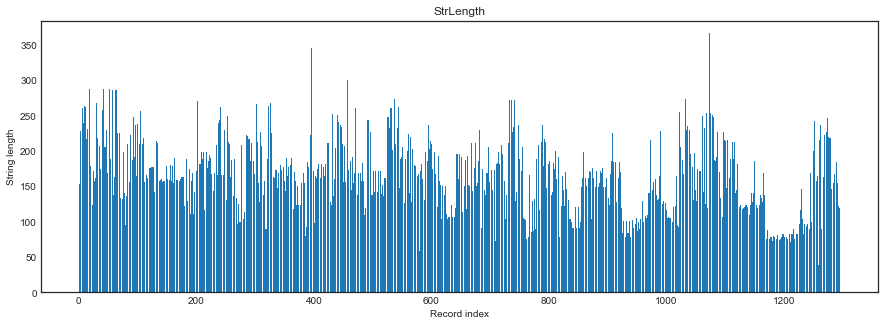

In [22]:
plt.figure(figsize=(15,5))
plt.bar(range(0,len(data_length),1),data_length)
plt.xlabel("Record index")
plt.ylabel("String length")
plt.title("StrLength")
plt.show()

Results dataframe

In [23]:
results_dataframe = pd.DataFrame(columns=['max_numberOf_clusters','max_editDistance','similarityThreshold','windowSize','metric','similarityVectors',"distanceMetricEmbedding","distanceMetric","number_of_permutations","ngramms","jaccard_with_chars",'Accuracy','Precision','Recall','F1','Time'])

### CORA: Jaccard execution

In [25]:
%%time

ngramms= 3                                  # If jaccard used, n-gramms are used
jaccard_withchars = True                    # n-gramms either of chars and either of words

# Prototype selection
max_numberOf_clusters= 1000                  # Νumber of loops for finding representatives, it is an upper bound of clusters.
max_dissimilarityDistance= 0.5                       # The threshold for the triangle inequality
distanceMetric= 'jaccard'                   # Distance metric between the strings when creating the space
prototypesFilterThr = 0.6                   # Prototypes must differ more than that threshold

# Embedding phase
distanceMetricEmbedding = 'l_inf'  # Embedding metric

# WTA algorithm
windowSize = 100                           # Vector size for WTA algo
number_of_permutations = 1                # WTA number of permutations
wtaM = 2

# Similarity evaluation
similarityVectors = 'ranked'                  # which vectors will be passed to WTA step
similarityThreshold = 0.6                    # Similarity threshold for the final step
metric = 'kendal'                             # Similarity metric between vectors

start = time.time()
model = RankedWTAHash(
    max_numberOf_clusters= max_numberOf_clusters,
    max_dissimilarityDistance= max_dissimilarityDistance,
    windowSize= windowSize,
    similarityThreshold= similarityThreshold,
    metric=metric,
    similarityVectors=similarityVectors,
    number_of_permutations = number_of_permutations,
    distanceMetric= distanceMetric,
    distanceMetricEmbedding = distanceMetricEmbedding,
    ngramms= ngramms,
    jaccard_withchars = jaccard_withchars,
    prototypesFilterThr = prototypesFilterThr,
    verboseLevel = 0,
    wtaM = wtaM
)
model.hackForDebug(labels_groundTruth, true_matrix)
model = model.fit(data)
acc,f1,precision,recall = model.evaluate(model.mapping_matrix, true_matrix)
exec_time = time.time() - start
results_dataframe.loc[len(results_dataframe)+1] = [max_numberOf_clusters,max_dissimilarityDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,jaccard_withchars,acc,precision,recall,f1,exec_time]


#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Prototype selection:   0%|          | 0/1295 [00:00<?, ?it/s]


- Final number of prototypes:  77

# Finished in 8.1850 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings:   0%|          | 0/1295 [00:00<?, ?it/s]

- Embeddings created

# Finished in 39.853 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


C:\Users\nikol\Desktop\GitHub\Entity-Resolution-in-Dissimilarity-Spaces\src\hash\wta.py:37: UserWarning: Window size greater than vector dimension
  warnings.warn("Window size greater than vector dimension")


WTA hashing:   0%|          | 0/1 [00:00<?, ?it/s]


- WTA number of buckets:  153

# Finished in 0.1939 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking:   0%|          | 0/153 [00:00<?, ?it/s]


# Finished in 11.585 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.13 %
F1-Score:  35.87 %
Recall:    25.49 %
Precision: 60.50 %
Wall time: 1min 1s


### CORA: Edit distance execution

In [26]:
# %%time

# # Prototype selection
# max_numberOf_clusters= 1000                  # Νumber of loops for finding representatives, it is an upper bound of clusters.
# max_dissimilarityDistance= 100                       # The threshold for the triangle inequality
# distanceMetric= 'edit'                   # Distance metric between the vectors when creating the space
# prototypesFilterThr = 100                # Prototypes must differ more that threshold

# # Embedding phase
# distanceMetricEmbedding = 'l_inf'  # Embedding metric

# # WTA algorithm
# windowSize= 37                             # Vector size for WTA algo
# number_of_permutations = 3                 # WTA number of permutations


# # Similarity evaluation
# similarityVectors='initial'                  # which vectors will be passed to WTA step
# similarityThreshold= 0.7                    # Similarity threshold for the final step
# metric='kendal'                             # Similarity metric between vectors


# start = time.time()
# model = RankedWTAHash(
#     max_numberOf_clusters= max_numberOf_clusters,    
#     max_dissimilarityDistance= max_dissimilarityDistance,    
#     windowSize= windowSize,    
#     similarityThreshold= similarityThreshold,    
#     metric= metric,    
#     similarityVectors=similarityVectors,    
#     number_of_permutations = number_of_permutations,
#     distanceMetric= distanceMetric,
#     distanceMetricEmbedding = distanceMetricEmbedding,
#     ngramms= ngramms,
#     jaccard_withchars = jaccard_withchars,
#     prototypesFilterThr = prototypesFilterThr
# )
# model.hackForDebug(labels_groundTruth, true_matrix)
# model = model.fit(data)
# acc,f1,precision,recall = model.evaluate(model.mapping_matrix,true_matrix, True)
# exec_time = time.time() - start
# results_dataframe.loc[len(results_dataframe)+1] = [max_numberOf_clusters,max_dissimilarityDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,jaccard_withchars,acc,precision,recall,f1,exec_time]

Wall time: 0 ns


### Space Visualization

[[ 22.65011548 -73.34031455]
 [-51.42666852  -9.24008209]
 [-54.94388423  -5.43829333]
 ...
 [169.24533611  -5.54026026]
 [160.77272197 -30.39548081]
 [159.25456256 -28.47363391]]


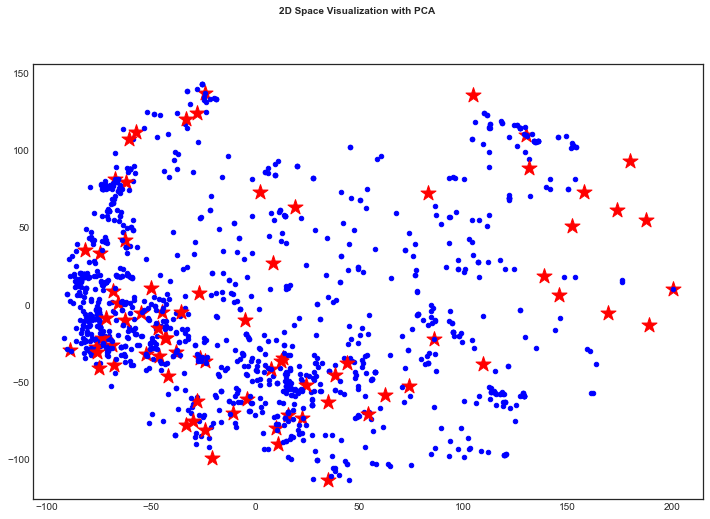

In [41]:
SpaceVisualization2D(model.Embeddings, model.prototypeArray, withPlotly=False)

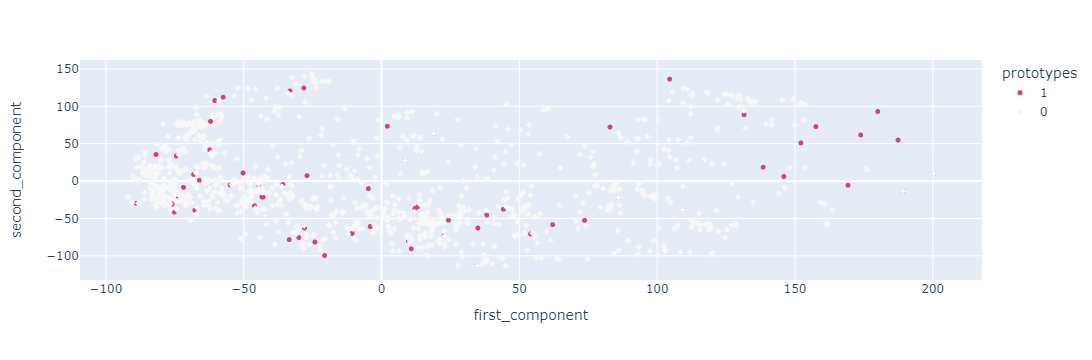

In [45]:
SpaceVisualization2D(model.Embeddings, model.prototypeArray)

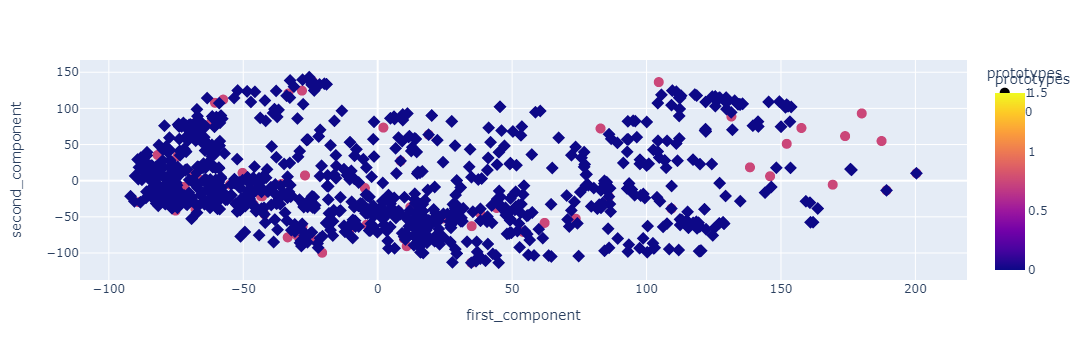

In [31]:
SpaceVisualization(model.Embeddings,model.prototypeArray)

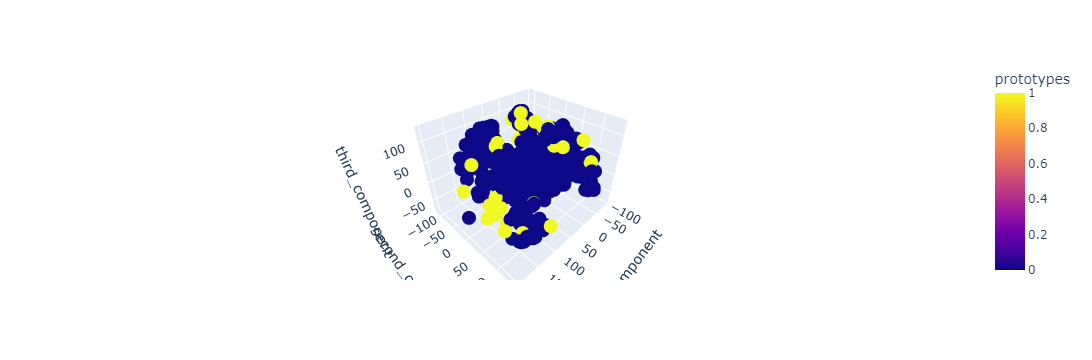

In [27]:
pcaComponents = PCA_SpaceVisualization_3D(model.Embeddings,model.prototypeArray)

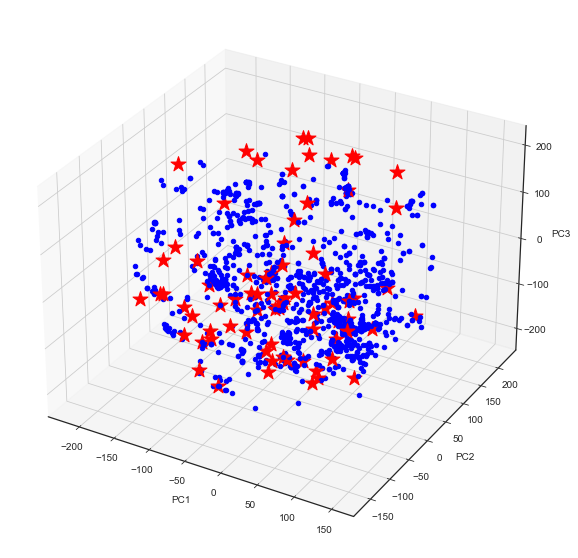

In [30]:
pcaComponents = PCA_SpaceVisualization_3D(model.rankedVectors,model.prototypeArray, decompositionMenthod='MSD')

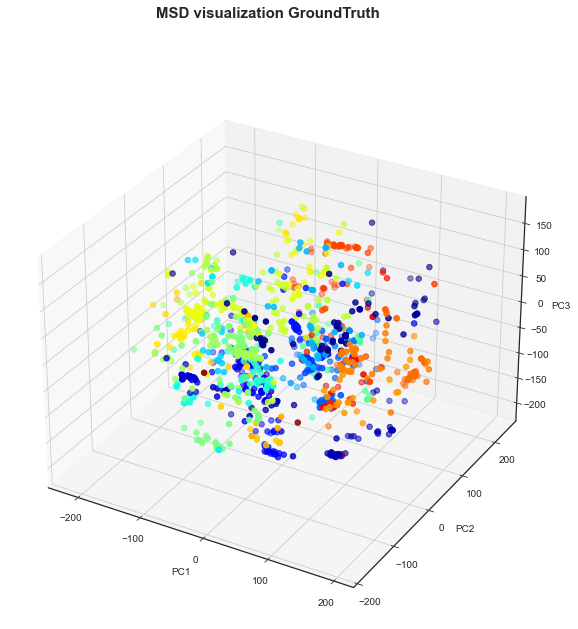

In [31]:
pcaComponents = WTA_PCA_SpaceVisualization_3D(
    model.rankedVectors, model.prototypeArray, model.HashedClusters, 
    withgroundruth=True, groundruth = labels_groundTruth, 
    title='MSD visualization GroundTruth', 
    decompositionMenthod='MSD'
)

Explained varianse of PCA: [0.23702883 0.15723168 0.09808114]


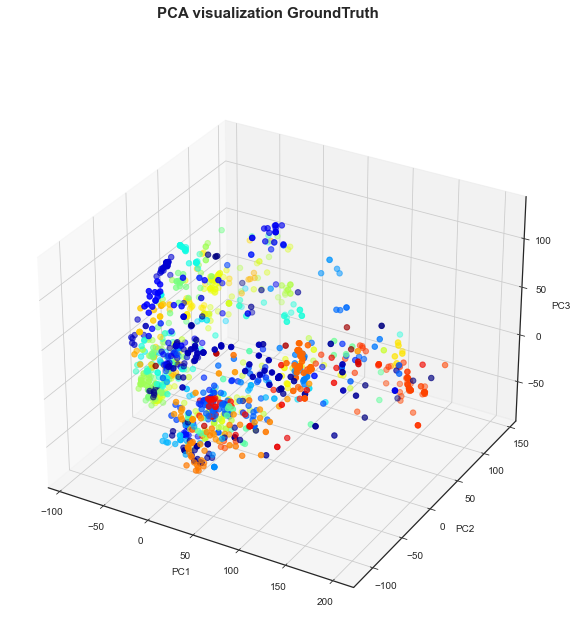

In [32]:
pcaComponents = WTA_PCA_SpaceVisualization_3D(
    model.rankedVectors, model.prototypeArray, model.HashedClusters,
    withgroundruth=True, groundruth=labels_groundTruth, title='PCA visualization GroundTruth', 
    decompositionMenthod='PCA'
)

### MMD${}^2$ error between distribution of Prototypes and whole Dataset

In [ ]:
myMMD2(model)

## Gridsearch with Optuna

In [33]:
import logging
import sys
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

In [34]:
def objective(trial):

    ngramms= trial.suggest_int("ngramms", 2, 3) 
    jaccard_withchars = trial.suggest_categorical("jaccard_withchars", [True, False])
    max_numberOf_clusters= trial.suggest_int("max_numberOf_clusters", 500, 1500) 
    distanceMetric = trial.suggest_categorical("distanceMetric", ["jaccard"])
    
    max_dissimilarityDistance= trial.suggest_float("max_dissimilarityDistance", 0.3, 0.8)
    
    prototypesFilterThr = trial.suggest_float("prototypesFilterThr", 0.5, 0.9)
    # --- Embedding phase
    if distanceMetric == "edit":
        distanceMetricEmbedding = trial.suggest_categorical("distanceMetricEmbedding", ["l_inf", "edit"])
    else:
        distanceMetricEmbedding = trial.suggest_categorical("distanceMetricEmbedding", ["l_inf", "jaccard", "euclid_jaccard"])
    # -- WTA algorithm
    windowSize= trial.suggest_int("windowSize", 5, 80) 
    number_of_permutations= trial.suggest_int("number_of_permutations", 1, 5) 
    wtaM= trial.suggest_int("wtaM", 1, 2) 
    # -- Similarity evaluation
    similarityVectors = trial.suggest_categorical("similarityVectors", ["initial"])
    similarityThreshold = trial.suggest_float("similarityThreshold", 0.6, 0.8)
    metric = trial.suggest_categorical("metric", ["pearson", "spearman", "kendal", "rbo"])

    model = RankedWTAHash(
        max_numberOf_clusters= max_numberOf_clusters,
        max_dissimilarityDistance= max_dissimilarityDistance,
        windowSize= windowSize,
        similarityThreshold= similarityThreshold,
        metric=metric,
        similarityVectors=similarityVectors,
        number_of_permutations = number_of_permutations,
        distanceMetric= distanceMetric,
        distanceMetricEmbedding = distanceMetricEmbedding,
        ngramms= ngramms,
        jaccard_withchars = jaccard_withchars,
        prototypesFilterThr = prototypesFilterThr,
        verboseLevel = -1,
        wtaM = wtaM
#         disableTqdm = True
    )
    model.hackForDebug(labels_groundTruth, true_matrix)
    model = model.fit(data)
    if model == None:
        precision = 0.0
        f1 = 0.0
        recall = 0.0
    else:
        acc,f1,precision,recall = model.evaluate(model.mapping_matrix, true_matrix)

    return recall

In [35]:
# Add stream handler of stdout to show the messages
# optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "best-params-jaccard-recall"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(directions=["maximize"], study_name=study_name, storage=storage_name, load_if_exists=True)

print("Number of finished trials: ", len(study.trials))

[I 2021-11-29 22:50:54,447] Using an existing study with name 'best-params-jaccard-recall' instead of creating a new one.


Number of finished trials:  30


In [ ]:
study.optimize(objective, n_trials=30, show_progress_bar=True)

In [36]:
studydf = study.trials_dataframe(attrs=("number", "value", "params", "state"))
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print("Best Trial: ", study.best_trial)
# print("Trials: ", study.trials)

Best params:  {'distanceMetric': 'jaccard', 'distanceMetricEmbedding': 'l_inf', 'jaccard_withchars': True, 'max_dissimilarityDistance': 0.7254478790406915, 'max_numberOf_clusters': 1096, 'metric': 'pearson', 'ngramms': 2, 'number_of_permutations': 2, 'prototypesFilterThr': 0.5067072384099558, 'similarityThreshold': 0.6083651878375449, 'similarityVectors': 'ranked', 'windowSize': 33, 'wtaM': 2}
Best value:  60.416666666666664
Best Trial:  FrozenTrial(number=16, values=[60.416666666666664], datetime_start=datetime.datetime(2021, 11, 29, 18, 30, 14, 336633), datetime_complete=datetime.datetime(2021, 11, 29, 18, 30, 52, 169861), params={'distanceMetric': 'jaccard', 'distanceMetricEmbedding': 'l_inf', 'jaccard_withchars': True, 'max_dissimilarityDistance': 0.7254478790406915, 'max_numberOf_clusters': 1096, 'metric': 'pearson', 'ngramms': 2, 'number_of_permutations': 2, 'prototypesFilterThr': 0.5067072384099558, 'similarityThreshold': 0.6083651878375449, 'similarityVectors': 'ranked', 'windo

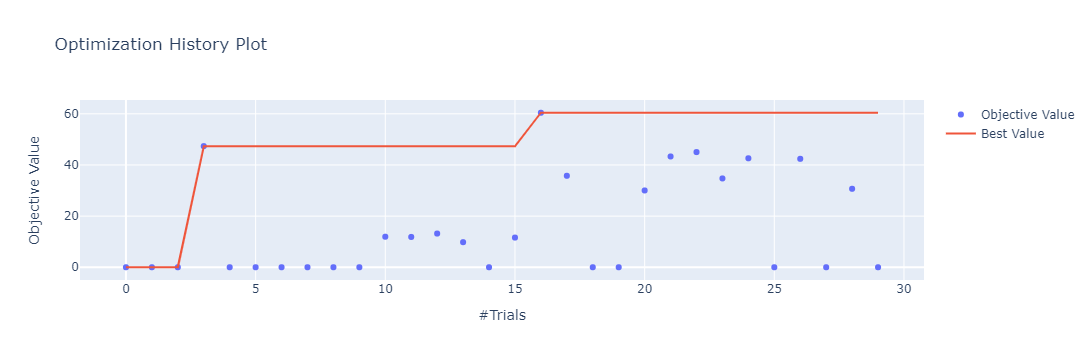

In [37]:
plot_optimization_history(study)

In [ ]:
plot_intermediate_values(study)

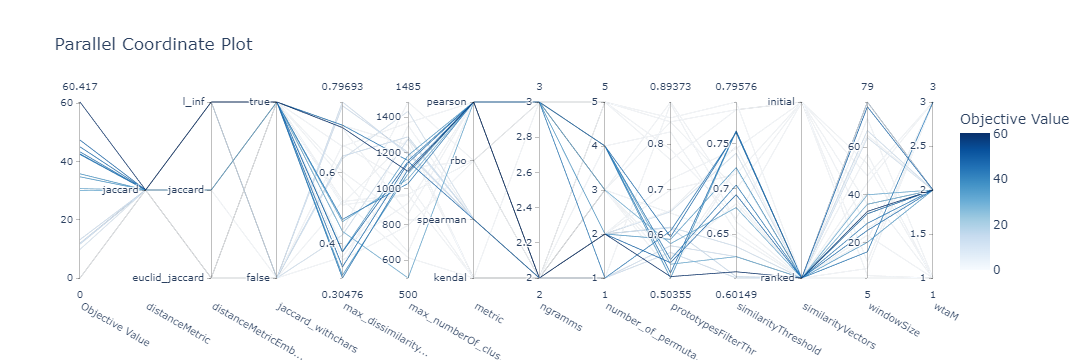

In [39]:
plot_parallel_coordinate(study)

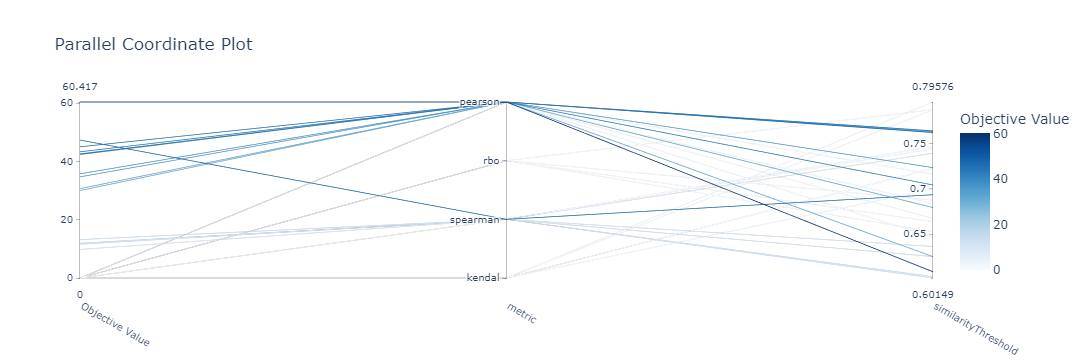

In [40]:
plot_parallel_coordinate(study, params=["metric", "similarityThreshold"])

In [ ]:
plot_contour(study)

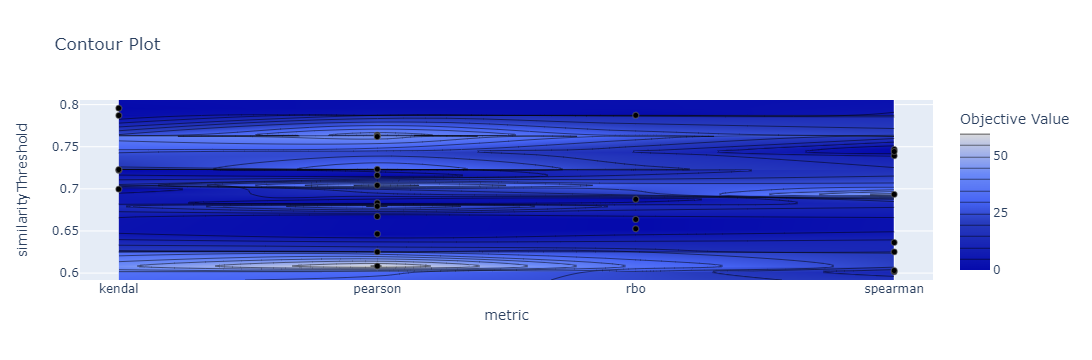

In [42]:
plot_contour(study, params=["metric", "similarityThreshold"])

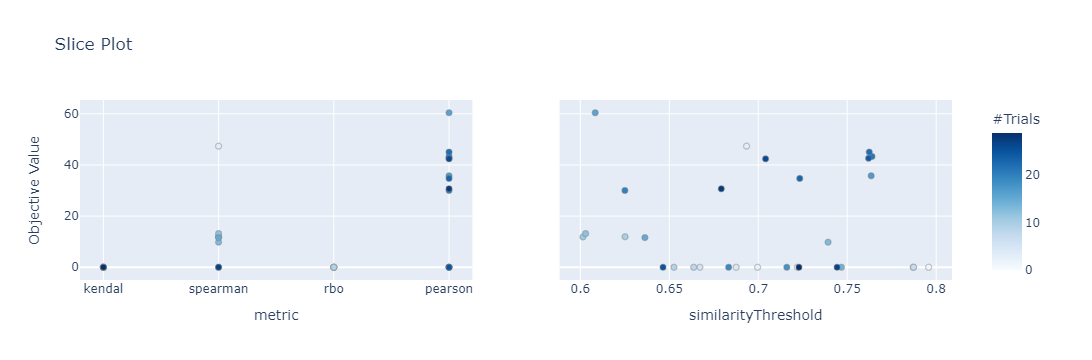

In [43]:
plot_slice(study,  params=["metric", "similarityThreshold"])

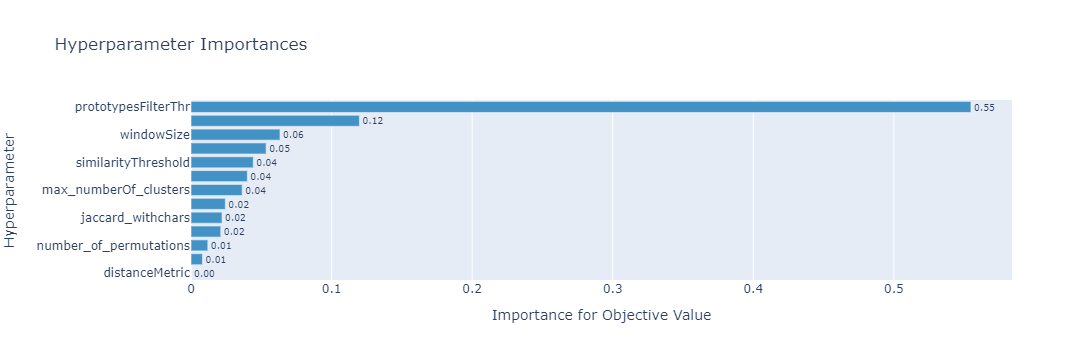

In [44]:
plot_param_importances(study)

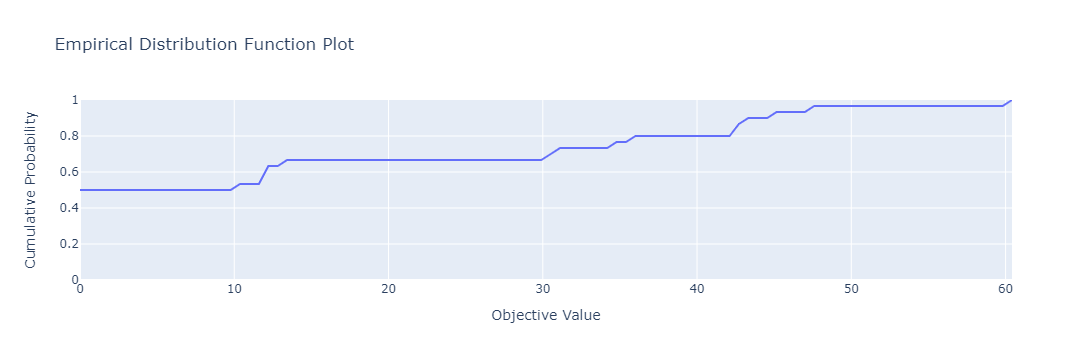

In [45]:
plot_edf(study)

In [ ]:
bestModel = set_params(study.best_params)
bestModel.hackForDebug(labels_groundTruth, true_matrix)
bestModel = bestModel.fit(data)
acc,f1,precision,recall = bestModel.evaluate(bestModel.mapping_matrix, true_matrix)

### Remarks

#### __[i]__ __Prototype selection__


First of all, we need to find some ways on evaluating the prototype selection algorithm. Vantage Spaces are not something new, but we need to examine its behaviour on CORA dataset.

Goals:

- __Variance__: We want prototypes to be as much different as possible. 
- __Number__: We need a large amount of prototypes.

Ways to evaluate the algorithm:

- Mean distance between selected prototypes
- Show a HeatMap of consisted of the distances
- Some greedy search on the parameters. Parameters to fine tunne:
    -  ```max_numberOf_clusters```: Νumber of loops for finding representatives, it is an upper bound of clusters.
    -  ```max_dissimilarityDistance```:  The threshold for the triangle inequality
    -  ```distanceMetric```:  Distance metric between the vectors when creating the space
    -  ```prototypesFilterThr```: Prototypes must differ more that threshold


All these parameters will be tested both for edit distance and jaccard with 3-grams.

__Maximum mean discrepancy (MMD)__, which measures the discrepancy between two distributions. The selection of prototypes creates a density distribution of prototypes. We want to evaluate whether the prototypes distribution differs from the data distribution. We estimate both with kernel density functions. The maximum mean discrepancy measures the difference between two distributions, which is the supremum over a function space of differences between the expectations according to the two distributions. All clear? Personally, I understand these concepts much better when I see how something is calculated with data. The following formula shows how to calculate the squared MMD measure (MMD2):
    $$
    MMD^2=\frac{1}{m^2}\sum_{i,j=1}^m{}k(z_i,z_j)-\frac{2}{mn}\sum_{i,j=1}^{m,n}k(z_i,x_j)+\frac{1}{n^2}\sum_{i,j=1}^n{}k(x_i,x_j)
    $$
    
- __k__ is a kernel function that measures the similarity of two points
- __m__ is the number of prototypes 
- __n__ is the number of data points x in our original dataset. 
- The prototypes z are a selection of data points x. 

    
Each point is multidimensional, that is it can have multiple features. The goal of MMD-critic is to minimize MMD2. The closer MMD2 is to zero, the better the distribution of the prototypes fits the data. The key to bringing MMD2 down to zero is the term in the middle, which calculates the average proximity between the prototypes and all other data points (multiplied by 2). If this term adds up to the first term (the average proximity of the prototypes to each other) plus the last term (the average proximity of the data points to each other), then the prototypes explain the data perfectly.  

__Remarks__

Two main factors:

- __numOfPrototypes__ and
- __protSelectionVariance__

The first one is the number of prototypes selected, which is very important as more prototypes will enhance model when creating the embeddings.

The second one is the average distance between all the prototypes selected. As this factor increases, the prototypes selected differ the most.


According to the above, best parameters so far:

- __Edit distance__


- __Jaccard with 3-grams__



#### __[ii]__ Fine tunning  __Embedding phase__

Ways to evaluate the __Embedding phase__:

- Use a PCA after embeddings made and check selected prototypes 

#### [iii] Fine tunning  __WTA algorithm__


Goals:

- __Ranked vectors dimension__
- __Permutations__: A number of permutations will be forced in order to better split data into buckets.

 
Parameters to fine tunne:

- ```windowSize```: Vector size after WTA
- ```number_of_permutations```: How many times vectors will be permuted and hashed

All these parameters will be tested both for edit distance and jaccard with 3-grams.

#### [iv] Fine tunning  __Similarity checking__

__Various similarity metrics to check__

These functions are for the similarity checking phase.
- __Spearman footrule distance__
- __Ravi Kumar generalized Kendall Tau__
- __Rank Biased Overlap (RBO)__
Article: https://towardsdatascience.com/rbo-v-s-kendall-tau-to-compare-ranked-lists-of-items-8776c5182899
- __Winner Takes All proposed__ 

#### [v] Model final fine tunning


There are four ways to check if the predictions are right or wrong:
- __TN__ / True Negative: the case was negative and predicted negative
- __TP__ / True Positive: the case was positive and predicted positive
- __FN__ / False Negative: the case was positive but predicted negative
- __FP__ / False Positive: the case was negative but predicted positive

__Precision — What percent of your predictions were correct?__


Precision is the ability of a classifier not to label an instance positive that is actually negative. For each class, it is defined as the ratio of true positives to the sum of a true positive and false positive.
Precision:- Accuracy of positive predictions.
Precision = TP/(TP + FP)


__Recall — What percent of the positive cases did you catch?__


Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.
Recall:- Fraction of positives that were correctly identified.
Recall = TP/(TP+FN)

__F1 score — What percent of positive predictions were correct?__


The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.
F1 Score = 2*(Recall * Precision) / (Recall + Precision)

__Support__


Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

# References

1.   [The dissimilarity representation for pattern recognition, a tutorial
Robert P.W. Duin and Elzbieta Pekalska Delft University of Technology, The Netherlands School of Computer Science, University of Manchester, United Kingdom](http://homepage.tudelft.nl/a9p19/presentations/DisRep_Tutorial_doc.pdf)